<a href="https://colab.research.google.com/github/mashrukh-zaman/bangla-digit-recognition/blob/main/Bangla_Digit_Recognizer(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
%matplotlib inline


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mashrukhzaman","key":"e064f368739c2dbdaebddcb37c9d39f0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:18<00:00, 33.8MB/s]
100% 1.91G/1.91G [00:18<00:00, 110MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "numta.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
FIG_WIDTH = 16
HEIGHT_PER_ROW = 3
RESIZE_DIM = 28

In [ ]:
#Training paths
paths_train_a = glob.glob(os.path.join('training-a', '*.png'))
paths_train_b = glob.glob(os.path.join('training-b', '*.png'))
paths_train_c = glob.glob(os.path.join('training-c', '*.png'))
paths_train_d = glob.glob(os.path.join('training-d', '*.png'))
paths_train_e = glob.glob(os.path.join('training-e', '*.png'))
paths_train_all = paths_train_a + paths_train_b + paths_train_c + paths_train_d + paths_train_e

In [ ]:
#Testing paths
paths_test_a = glob.glob(os.path.join('testing-a', '*.png'))
paths_test_b = glob.glob(os.path.join('testing-b', '*.png'))
paths_test_c = glob.glob(os.path.join('testing-c', '*.png'))
paths_test_d = glob.glob(os.path.join('testing-d', '*.png'))
paths_test_e = glob.glob(os.path.join('testing-e', '*.png'))
paths_test_f = glob.glob(os.path.join('testing-f', '*.png')) + glob.glob(os.path.join('testing-f', '*.jpg'))
paths_test_auga = glob.glob(os.path.join('testing-auga', '*.png'))
paths_test_augc = glob.glob(os.path.join('testing-augc', '*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

In [ ]:
#Labeling
path_label_train_a = os.path.join('training-a.csv')
path_label_train_b = os.path.join('training-b.csv')
path_label_train_c = os.path.join('training-c.csv')
path_label_train_d = os.path.join('training-d.csv')
path_label_train_e = os.path.join('training-e.csv')

In [ ]:
def get_key(path):
    key = path.split(sep = os.sep)[-1]
    return key

def get_data(paths_img, path_label= None, resize_dim = None):
    X = []
    for i, path in enumerate(paths_img):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if resize_dim is not None:
            img = cv2.resize(img, (resize_dim, resize_dim), interpolation = cv2.INTER_AREA)
        gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
        img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
        kernel = np.array([[-1, -1, -1], [-1, 9, -1],[-1, -1, -1]])
        img - cv2.filter2D(img, -1, kernel)
        X.append(img)
            
        if i == len(paths_img)-1:
            end = '\n'
        else: 
            end = '\r'
        print('processed {}/{}'.format(i+1, len(paths_img)), end = end)
            
    X = np.array(X)
    if path_label is None:
        return X
    else:
        df = pd.read_csv(path_label)
        df = df.set_index('filename')
        y_label = [df.loc[get_key(path)]['digit'] for path in paths_img]
        y = to_categorical(y_label, 10)
        return X, y

In [ ]:
def imshow_group(X, y, y_pred = None, n_per_row = 10, phase = 'processed'):
    n_sample = len(X)
    img_dim = X.shape[1]
    j = np.ceil(n_sample/n_per_row)
    fig = plt.figure(figsize = (FIG_WIDTH, HEIGHT_PER_ROW*j))
    for i, img in enumerate(X):
        plt.subplot(j, n_per_row, i + 1)
        plt.imshow(img)
        if phase == 'processed':
            plot.title(np.argmax(y[i]))
        if phase == 'prediction':
            top_n = 3
            ind_sorted = np.argsort(y_pred[i])[::-1]
            h = img_dim+4
            for k in range(top_n):
                string = 'pred: {} ({:.0f}%\n)'.format(ind_sorted[k], 
                                                       y_pred[i, ind_sorted[k]]*100)
                plt.text(img_dim/2, 
                         h, 
                         string, 
                         horizontalalignment = 'center', 
                         verticalalignment = 'center')
                h += 4
            if y is not None:
                plt.text(img_dim/2, 
                         -4, 
                         'true label: {}'.format(np.argmax(y[i])), 
                         horizontalalignment = 'center', 
                         verticalalignment = 'center')
            plt.axis('off')
        plt.show()

In [ ]:
X_train_a, y_train_a = get_data(paths_train_a, path_label_train_a, resize_dim = RESIZE_DIM)
X_train_b, y_train_b = get_data(paths_train_b, path_label_train_b, resize_dim = RESIZE_DIM)
X_train_c, y_train_c = get_data(paths_train_c, path_label_train_c, resize_dim = RESIZE_DIM)
X_train_d, y_train_d = get_data(paths_train_d, path_label_train_d, resize_dim = RESIZE_DIM)
X_train_e, y_train_e = get_data(paths_train_e, path_label_train_e, resize_dim = RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [ ]:
X_train_all = np.concatenate((X_train_a, X_train_b, X_train_c, X_train_d, X_train_e), axis = 0)
y_train_all = np.concatenate((y_train_a, y_train_b, y_train_c, y_train_d, y_train_e), axis = 0)
X_train_all.shape, y_train_all.shape

((72045, 32, 32), (72045, 10))

In [ ]:
X_show_all = X_train_all

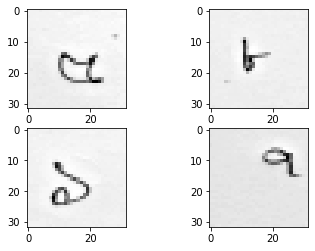

In [ ]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap = plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap = plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap = plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap = plt.get_cmap('gray'))
plt.show()

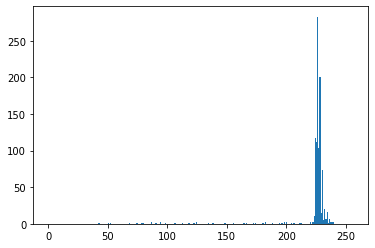

In [ ]:
imgg = X_train_all[1]
hist = cv2.calcHist([imgg], [0], None, [256], [0, 256])
plt.hist(imgg.ravel(), 256, [0, 256])
plt.show()

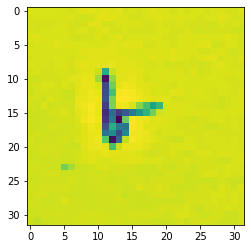

In [ ]:
plt.imshow(X_train_all[1])

In [ ]:
X_test_a = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_b = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_c = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_d = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_e = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_f = get_data(paths_test_a, resize_dim = RESIZE_DIM)
X_test_auga = get_data(paths_test_auga, resize_dim = RESIZE_DIM)
X_test_augc = get_data(paths_test_augc, resize_dim = RESIZE_DIM)

processed 3489/3489
processed 3489/3489
processed 3489/3489
processed 3489/3489
processed 3489/3489
processed 3489/3489
processed 2168/2168
processed 2106/2106


In [ ]:
X_test_all = np.concatenate((X_test_a, 
                             X_test_b, 
                             X_test_c, 
                             X_test_d, 
                             X_test_e, 
                             X_test_f, 
                             X_test_auga, 
                             X_test_augc))

In [ ]:
X_tshow_all = X_test_all
X_tshow_all.shape

(25208, 32, 32)

In [ ]:
X_train_all = X_train_all.reshape(X_train_all.shape[0], 32, 32, 1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0], 32, 32, 1).astype('float32')

In [ ]:
X_train_all.shape

(72045, 32, 32, 1)

Normalize Data

In [ ]:
X_train_all = X_train_all/255
X_test_all = X_test_all/255

In [ ]:
indices = list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

#Training Data
ind = int(len(indices)*0.80)
X_train = X_train_all[indices[:ind]]
y_train = y_train_all[indices[:ind]]

#Validation Data
X_val = X_train_all[indices[-(len(indices)-ind):]]
y_val = y_train_all[indices[-(len(indices)-ind):]]

In [ ]:
def my_model(img_size = 32, channels = 1):
    model = keras.Sequential()
    input_shape = (img_size, img_size, channels)
    model.add(Conv2D(32, 
                     (5, 5), 
                     input_shape = input_shape, 
                     activation = 'relu', 
                     padding = 'same'))
    model.add(Conv2D(32, 
                     (5, 5), 
                     activation = 'relu', 
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(128, 
                    (3, 3),
                    activation = 'relu',
                    padding = 'same'))
    model.add(Conv2D(128, 
                    (3, 3),
                    activation = 'relu',
                    padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(256, 
                    (3, 3),
                    activation = 'relu',
                    padding = 'same'))
    model.add(Conv2D(256, 
                    (3, 3),
                    activation = 'relu',
                    padding = 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
    
    #model.summary()
    
    return model

model = my_model()
model.summary()              

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       5

In [ ]:
path_model = 'model_filter.h5'
tensorflow.keras.backend.clear_session() #Destroys the current TF graph and session, and creates a new one.
tensorflow.keras.backend.set_value(model.optimizer.lr, 1e-3)

#Fit the model
h = model.fit(x = X_train,
             y = y_train,
             batch_size = 64,
             epochs = 30,
             verbose = 1,
             validation_data = (X_val, y_val),
             shuffle = True,
             callbacks = [ModelCheckpoint(filepath = path_model),])

Epoch 1/30
901/901 [==============================] - 11s 13ms/step - loss: 1.2506 - accuracy: 0.5329 - val_loss: 0.3600 - val_accuracy: 0.8894
Epoch 2/30
901/901 [==============================] - 11s 12ms/step - loss: 0.1700 - accuracy: 0.9507 - val_loss: 0.8277 - val_accuracy: 0.8448
Epoch 3/30
901/901 [==============================] - 11s 12ms/step - loss: 0.1069 - accuracy: 0.9697 - val_loss: 0.1647 - val_accuracy: 0.9547
Epoch 4/30
901/901 [==============================] - 11s 12ms/step - loss: 0.0804 - accuracy: 0.9777 - val_loss: 0.3286 - val_accuracy: 0.9256
Epoch 5/30
901/901 [==============================] - 11s 12ms/step - loss: 0.0673 - accuracy: 0.9809 - val_loss: 0.0984 - val_accuracy: 0.9740
Epoch 6/30
901/901 [==============================] - 11s 12ms/step - loss: 0.0578 - accuracy: 0.9838 - val_loss: 0.2815 - val_accuracy: 0.9278
Epoch 7/30
901/901 [==============================] - 11s 12ms/step - loss: 0.0553 - accuracy: 0.9839 - val_loss: 0.0712 - val_accuracy:

In [ ]:
predictions_prob = model.predict(X_test_all)

In [ ]:
n_sample = 200
np.random.seed(42)
ind = np.random.randint(0, len(X_test_all), size = n_sample)

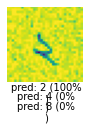

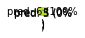

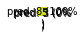

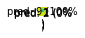

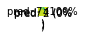

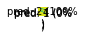

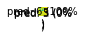

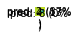

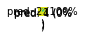

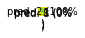

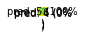

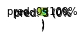

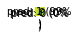

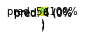

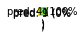

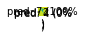

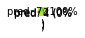

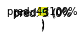

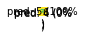

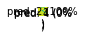

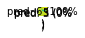

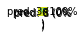

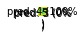

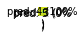

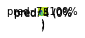

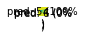

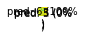

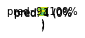

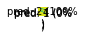

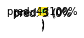

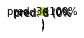

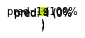

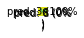

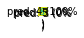

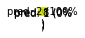

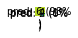

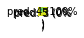

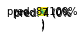

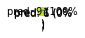

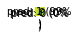

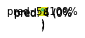

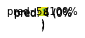

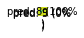

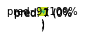

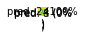

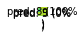

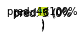

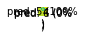

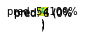

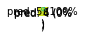

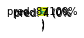

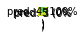

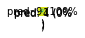

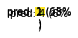

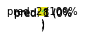

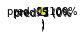

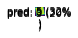

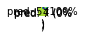

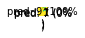

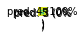

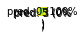

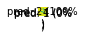

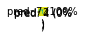

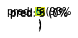

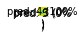

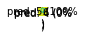

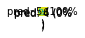

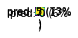

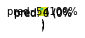

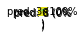

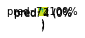

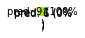

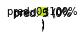

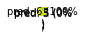

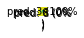

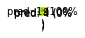

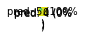

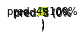

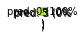

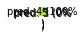

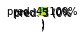

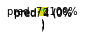

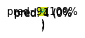

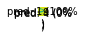

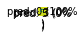

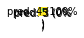

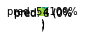

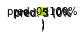

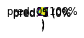

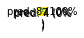

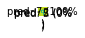

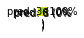

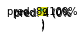

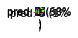

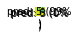

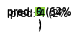

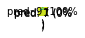

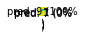

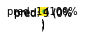

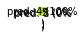

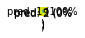

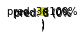

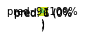

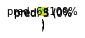

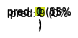

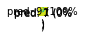

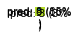

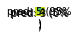

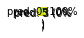

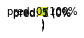

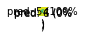

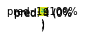

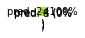

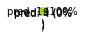

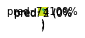

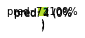

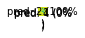

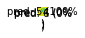

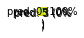

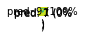

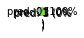

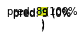

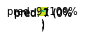

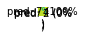

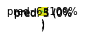

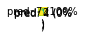

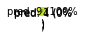

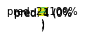

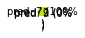

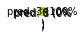

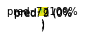

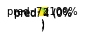

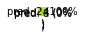

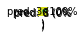

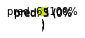

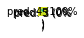

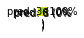

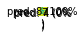

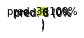

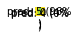

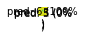

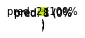

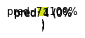

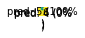

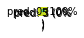

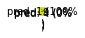

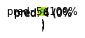

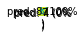

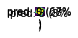

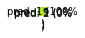

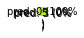

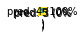

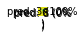

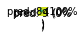

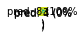

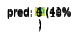

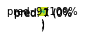

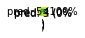

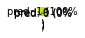

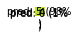

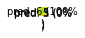

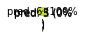

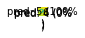

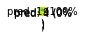

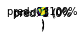

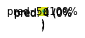

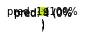

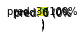

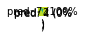

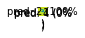

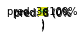

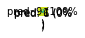

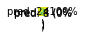

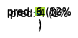

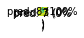

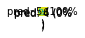

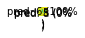

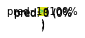

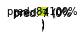

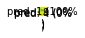

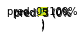

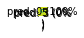

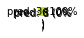

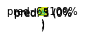

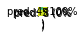

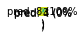

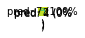

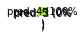

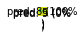

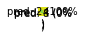

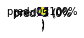

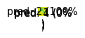

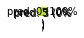

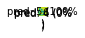

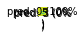

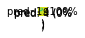

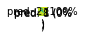

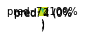

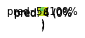

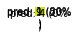

In [ ]:
imshow_group(X = X_tshow_all[ind],
            y = None,
            y_pred = predictions_prob[ind],
            phase = 'prediction')